In [1]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy

In [2]:
##FCC Data from June 2019 (Most current)
fcc_bbnd_june19 = pd.read_csv('../data/FCC_Broadband/TN-Fixed-Jun2019-v1.csv')

##For details on original columns: https://www.fcc.gov/general/explanation-broadband-deployment-data
# Code	Technology of Transmission
# 10	Asymmetric xDSL
# 11	ADSL2, ADSL2+
# 12	VDSL
# 20	Symmetric xDSL*
# 30	Other Copper Wireline (all copper-wire based technologies other than xDSL; Ethernet over copper and T-1 are examples)
# 40	Cable Modem other than DOCSIS 1, 1.1, 2.0, 3.0, or 3.1
# 41	Cable Modem – DOCSIS 1, 1.1 or 2.0
# 42	Cable Modem – DOCSIS 3.0
# 43	Cable Modem – DOCSIS 3.1
# 50	Optical Carrier / Fiber to the end user (Fiber to the home or business end user, does not include “fiber to the curb”)
# 60	Satellite
# 70	Terrestrial Fixed Wireless
# 90	Electric Power Line
# 0	All Other

## Urban Area definitions from 2018 Census Geographies 
## 'R' = Rural 'C' = Urban Cluster (2,500-50,000) 'U' = Urbanized Area (50,000+) 
urban_area_shape = gpd.read_file('../data/UrbanAreaShape2018/tl_2018_us_uac10.shp')

## Define central point of TN census tracts from 2010 Census Geographies
centroid_df = pd.read_csv('../data/CenPop2010_Mean_TR47.txt', converters={'TRACTCE': lambda x: str(x), 'COUNTYFP': lambda y: str(y)})

print(fcc_bbnd_june19.shape)
print(fcc_bbnd_june19.info())

print(urban_area_shape.shape)
print(urban_area_shape.info())

print(centroid_df.shape)
print(centroid_df.info())

(1484085, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484085 entries, 0 to 1484084
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   LogRecNo            1484085 non-null  int64  
 1   Provider_Id         1484085 non-null  int64  
 2   FRN                 1484085 non-null  int64  
 3   ProviderName        1484085 non-null  object 
 4   DBAName             1484085 non-null  object 
 5   HoldingCompanyName  1484085 non-null  object 
 6   HocoNum             1484085 non-null  int64  
 7   HocoFinal           1484085 non-null  object 
 8   StateAbbr           1484085 non-null  object 
 9   BlockCode           1484085 non-null  int64  
 10  TechCode            1484085 non-null  int64  
 11  Consumer            1484085 non-null  int64  
 12  MaxAdDown           1484085 non-null  float64
 13  MaxAdUp             1484085 non-null  float64
 14  Business            1484085 non-null  int64  
 15  M

In [3]:
## TN Tracts shape
tract_shape = gpd.read_file('../data/shapefiles/tl_2018_47_tract.shp')

In [4]:
tract_shape.crs
tract_shape.head()
tract_shape = tract_shape[['GEOID', 'geometry']]

In [5]:
tract_shape.shape

(1497, 2)

In [6]:
urban_area_shape = urban_area_shape[['GEOID10', 'NAME10', 'UATYP10', 'ALAND10', 'geometry']]

In [7]:
print(fcc_bbnd_june19.groupby('TechCode').size())
print('\n')
print(fcc_bbnd_june19.groupby('Consumer').size())
print('\n')
print(fcc_bbnd_june19.groupby('Business').size())
print('\n')
print(fcc_bbnd_june19.groupby(['Consumer','Business']).size())

TechCode
10     66864
11    112629
12     67315
20       834
30      9860
40       334
41        61
42     15317
43    121866
50     68334
60    944385
70     76286
dtype: int64


Consumer
0     261604
1    1222481
dtype: int64


Business
0     258113
1    1225972
dtype: int64


Consumer  Business
0         1           261604
1         0           258113
          1           964368
dtype: int64


In [8]:
## Add column for census tract
fcc_bbnd_june19['TractCode'] = fcc_bbnd_june19['BlockCode'].apply(lambda x: str(x)[0:11])

In [9]:
## Drop extraneous columns
all_june19 = fcc_bbnd_june19.drop(['FRN', 'DBAName', 'HoldingCompanyName', 'HocoFinal', 'StateAbbr'], axis=1, inplace=False)

In [10]:
## Add frames with only sat and no sat

only_sat_june19 = fcc_bbnd_june19.loc[fcc_bbnd_june19['TechCode'] == 60]
no_sat_june19 = fcc_bbnd_june19.loc[fcc_bbnd_june19['TechCode'] != 60]

print(all_june19.groupby('TractCode').size())
print(only_sat_june19.groupby('TractCode').size())
print(no_sat_june19.groupby('TractCode').size())
print('\n')
print(all_june19.groupby('BlockCode').size())
print(only_sat_june19.groupby('BlockCode').size())
print(no_sat_june19.groupby('BlockCode').size())
print('\n')
print(all_june19.shape)
print(only_sat_june19.shape)
print(no_sat_june19.shape)

TractCode
47001020100     762
47001020201     509
47001020202     998
47001020300     397
47001020400     765
               ... 
47189030800    2146
47189030901     936
47189030903    1467
47189030904    1659
47189031000    2456
Length: 1497, dtype: int64
TractCode
47001020100     480
47001020201     309
47001020202     614
47001020300     200
47001020400     440
               ... 
47189030800    1512
47189030901     633
47189030903    1076
47189030904    1173
47189031000    1648
Length: 1497, dtype: int64
TractCode
47001020100    282
47001020201    200
47001020202    384
47001020300    197
47001020400    325
              ... 
47189030800    634
47189030901    303
47189030903    391
47189030904    486
47189031000    808
Length: 1497, dtype: int64


BlockCode
470010201001000    5
470010201001001    4
470010201001002    7
470010201001003    6
470010201001004    7
                  ..
471890310004062    8
471890310004063    5
471890310004064    5
471890310004065    7
471890310004066   

In [11]:
## Explore further
no_sat_june19.groupby(['TractCode', 'ProviderName', 'TechCode']).size().reset_index()

,TractCode,ProviderName,TechCode,0
0,47001020100,"BellSouth Telecommunications, Inc.",10,41
1,47001020100,"BellSouth Telecommunications, Inc.",11,70
2,47001020100,"BellSouth Telecommunications, Inc.",12,41
3,47001020100,"BellSouth Telecommunications, Inc.",50,7
4,47001020100,"Birch Communications, Inc.",10,2
...,...,...,...,...
13773,47189031000,"BellSouth Telecommunications, Inc.",70,122
13774,47189031000,"Charter Communications, Inc.",43,91
13775,47189031000,DE KALB TELEPHONE COOPERATIVE INC,11,205
13776,47189031000,DE KALB TELEPHONE COOPERATIVE INC,12,93


In [12]:
## Find how many census blocks are in each tract
count_blocks = no_sat_june19.groupby('TractCode')['BlockCode'].nunique().reset_index()
count_blocks.rename(columns={'BlockCode': 'CountBlocks'}, inplace=True)
count_blocks.head()

,TractCode,CountBlocks
0,47001020100,91
1,47001020201,77
2,47001020202,127
3,47001020300,50
4,47001020400,94


In [13]:
## Merge block count into fcc df
no_sat_june19_countd = no_sat_june19.merge(count_blocks, how='inner', on='TractCode')

In [14]:
consumers_served = no_sat_june19_countd.groupby(['TractCode', 'BlockCode', 'ProviderName', 'CountBlocks'])['Consumer'].max().reset_index()
consumers_served = consumers_served[consumers_served['Consumer'] != 0]
## In each tract that is served (consumer side only) by a provider, how many blocks do they serve? TODO: Business breakdown as well.
block_sum_consumers = consumers_served.groupby(['TractCode', 'ProviderName', 'CountBlocks'])['Consumer'].sum().reset_index()
block_sum_consumers['Proportion Served'] = round((100 * block_sum_consumers['Consumer'] / block_sum_consumers['CountBlocks']), 2)
block_sum_consumers['Substantially Served'] = block_sum_consumers['Proportion Served'] >= 15.0

In [15]:
block_sum_consumers.info()
##block_sum_consumers['Substantially Served'] = block_sum_consumers['Substantially Served'].fillna(-1)
##block_sum_consumers['Substantially Served'] = block_sum_consumers['Substantially Served'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TractCode             5053 non-null   object 
 1   ProviderName          5053 non-null   object 
 2   CountBlocks           5053 non-null   int64  
 3   Consumer              5053 non-null   int64  
 4   Proportion Served     5053 non-null   float64
 5   Substantially Served  5053 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 202.4+ KB


In [16]:
count_provider_tracts = block_sum_consumers.groupby('ProviderName')['Substantially Served'].sum().reset_index()
count_provider_tracts.sort_values('Substantially Served', ascending=False).head(50)

,ProviderName,Substantially Served
9,"BellSouth Telecommunications, Inc.",1191
15,"COMCAST CABLE COMMUNICATIONS, LLC",874
19,"Charter Communications, Inc.",482
82,UNITED STATES CELLULAR CORPORATION,267
18,"CenturyLink, Inc.",123
24,EPB Fiber Optics,82
73,TDS TELECOMMUNICATIONS LLC,61
32,Frontier Communications Corporation,58
54,Monster Broadband,43
85,"United Communications, Inc.",41


In [17]:
block_sum_consumers.to_csv('block_sum_consumers.csv')

In [18]:
companies_serving_tract = block_sum_consumers.groupby('TractCode')['Substantially Served'].sum().reset_index()
companies_serving_tract.head()

,TractCode,Substantially Served
0,47001020100,3
1,47001020201,3
2,47001020202,3
3,47001020300,3
4,47001020400,3


<AxesSubplot:>

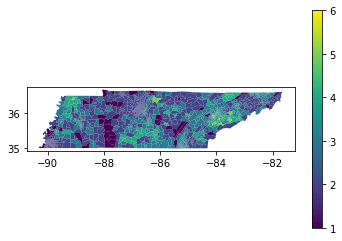

In [19]:
##Count how many companies serve each tract substantially 

mappable_total_cos = tract_shape.merge(companies_serving_tract, how='left', left_on='GEOID', right_on='TractCode')
mappable_total_cos.plot(column='Substantially Served', legend=True)

In [20]:
print(block_sum_consumers[block_sum_consumers['Substantially Served'] == True].shape)
print(block_sum_consumers[block_sum_consumers['Substantially Served'] == False].shape)

(3774, 6)
(1279, 6)


(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)
(1497, 8)


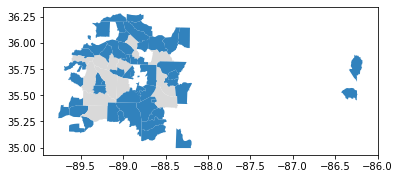

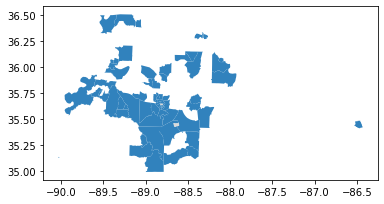

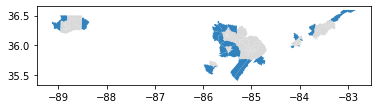

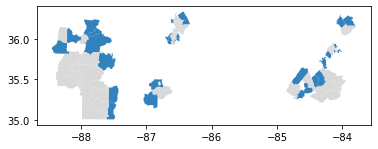

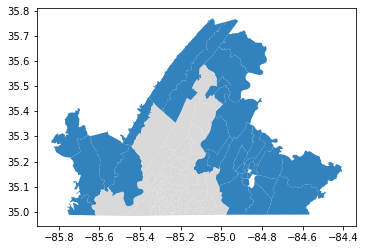

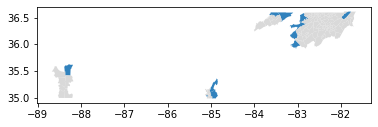

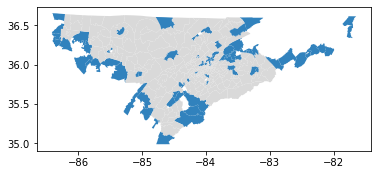

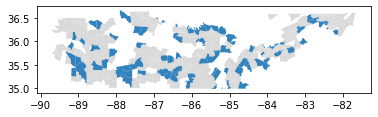

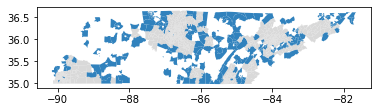

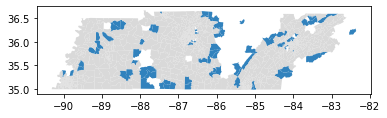

In [21]:
map_top_providers_dfs = []
top_n_providers = list(block_sum_consumers.groupby('ProviderName').size().sort_values().tail(10).index)
rp = copy.copy(cm.get_cmap('tab20c'))
for x in top_n_providers:
    provider_sub = block_sum_consumers[block_sum_consumers['ProviderName'] == x]
    mappable = tract_shape.merge(provider_sub, how='left', left_on='GEOID', right_on='TractCode')
    print(mappable.shape)
    map_top_providers_dfs.append(mappable)
for provider_map in map_top_providers_dfs:
    provider_map.plot(column='Substantially Served', cmap=rp)

In [22]:
charter_sub = block_sum_consumers[block_sum_consumers['ProviderName'] == 'Charter Communications, Inc.']

In [23]:
charter_geo = tract_shape.merge(charter_sub, how='outer', left_on='GEOID', right_on='TractCode')

In [24]:
charter_geo_filled = charter_geo.fillna(0.0001)

<AxesSubplot:>

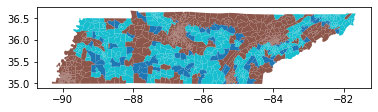

In [25]:
charter_geo_filled.plot(column='Substantially Served')

In [26]:
sub_tract = no_sat_june19[no_sat_june19['TractCode'] == '47189031000']
sub_tract.head(20)
sub_tract.groupby(['BlockCode']).size()

BlockCode
471890310001002    4
471890310001006    2
471890310001007    2
471890310001008    2
471890310001009    2
                  ..
471890310004062    4
471890310004063    1
471890310004064    1
471890310004065    3
471890310004066    4
Length: 365, dtype: int64

In [27]:
centroid_df.drop('POPULATION', axis=1, inplace=True)

In [28]:
centroid_df = centroid_df.astype({'STATEFP': 'str'}, copy=False)

In [29]:
centroid_df['TractCode'] = centroid_df['STATEFP'] + centroid_df['COUNTYFP'] + centroid_df['TRACTCE']

In [30]:
##Compare centroid tracts to fcc data tracts - to show there are no tracts without data in the fcc no satellite group
no_sat_tract = no_sat_june19['TractCode'].unique()
centroid_tract = centroid_df['TractCode']
print(no_sat_tract.shape)
print(centroid_tract.shape)

(1497,)
(1497,)


In [31]:
centroid_df['geometry'] = centroid_df.apply(lambda x: Point((float(x['LONGITUDE']), float(x['LATITUDE']))), axis=1)

In [32]:
centroid_geo = gpd.GeoDataFrame(centroid_df, crs = urban_area_shape.crs, geometry = centroid_df['geometry'])
centroid_geo = centroid_geo[['LATITUDE', 'LONGITUDE', 'TractCode', 'geometry']]

In [33]:
centroid_geo.shape

(1497, 4)

In [34]:
ua_of_census_tracts = gpd.sjoin(centroid_geo, urban_area_shape, op = 'within')
ua_of_census_tracts.head()

,LATITUDE,LONGITUDE,TractCode,geometry,index_right,GEOID10,NAME10,UATYP10,ALAND10
0,36.001828,-84.268796,47001020100,POINT (-84.26880 36.00183),865,45640,"Knoxville, TN",U,1134806494
1,36.017235,-84.213287,47001020201,POINT (-84.21329 36.01723),865,45640,"Knoxville, TN",U,1134806494
2,36.022426,-84.228827,47001020202,POINT (-84.22883 36.02243),865,45640,"Knoxville, TN",U,1134806494
3,36.041852,-84.226627,47001020300,POINT (-84.22663 36.04185),865,45640,"Knoxville, TN",U,1134806494
4,36.026023,-84.255785,47001020400,POINT (-84.25579 36.02602),865,45640,"Knoxville, TN",U,1134806494


In [35]:
ua_of_census_tracts.drop('index_right', axis=1, inplace=True)

In [36]:
##Find any rows where Tract is not in the spatially merged df
centroid_geo_rural = centroid_geo[centroid_geo['TractCode'].isin(ua_of_census_tracts['TractCode'].tolist()) == False]
centroid_geo_rural.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 606 entries, 7 to 1496
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LATITUDE   606 non-null    float64 
 1   LONGITUDE  606 non-null    float64 
 2   TractCode  606 non-null    object  
 3   geometry   606 non-null    geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 23.7+ KB


In [37]:
centroid_rural_match_cols = pd.concat([centroid_geo_rural, pd.DataFrame(columns=['GEOID10', 'NAME10', 'UATYP10', 'ALAND10'])])
centroid_rural_match_cols['UATYP10'] = 'R'
centroid_rural_match_cols['ALAND10'] = centroid_rural_match_cols['ALAND10'].fillna(np.nan)

In [38]:
centroid_rural_match_cols.head()

,LATITUDE,LONGITUDE,TractCode,geometry,GEOID10,NAME10,UATYP10,ALAND10
7,36.187349,-84.212278,47001020700,POINT (-84.21228 36.18735),NaN,NaN,R,NaN
8,36.209390,-84.141887,47001020800,POINT (-84.14189 36.20939),NaN,NaN,R,NaN
9,36.202792,-84.030302,47001020901,POINT (-84.03030 36.20279),NaN,NaN,R,NaN
11,36.052115,-84.293492,47001021000,POINT (-84.29349 36.05212),NaN,NaN,R,NaN
12,36.076311,-84.182827,47001021100,POINT (-84.18283 36.07631),NaN,NaN,R,NaN


In [39]:
tract_by_ua_w_rural = pd.concat([centroid_rural_match_cols, ua_of_census_tracts], axis=0)

In [40]:
print(tract_by_ua_w_rural.shape)
print(tract_by_ua_w_rural.info())
tract_by_ua_w_rural.head(50)
tract_by_ua_w_rural['UATYP10'].unique()

(1497, 8)
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1497 entries, 7 to 1491
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LATITUDE   1497 non-null   float64 
 1   LONGITUDE  1497 non-null   float64 
 2   TractCode  1497 non-null   object  
 3   geometry   1497 non-null   geometry
 4   GEOID10    891 non-null    object  
 5   NAME10     891 non-null    object  
 6   UATYP10    1497 non-null   object  
 7   ALAND10    891 non-null    float64 
dtypes: float64(3), geometry(1), object(4)
memory usage: 105.3+ KB
None


array(['R', 'U', 'C'], dtype=object)

In [41]:
census_url = 'https://api.census.gov/data'
year = '2010'
dataset = 'dec/sf1'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['P001001']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'urban area:*'  ## zctas
##predicates['in'] = 'state:47'
request = requests.get(base_url, params=predicates)
##col_names = ['NAME', 'Population', 'zip']
census_df = pd.DataFrame(data=request.json()[1:])

##https://api.census.gov/data/2010/dec/sf1?get=P001001,NAME&for=urban%20rural:*&in=state:01%20county:087%20county%20subdivision:93230%20place/remainder%20(or%20part):77304%20tract%20(or%20part):231900

In [42]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['B01003_001E']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'urban area:*'  ## zctas
##predicates['in'] = 'urban area:*'

request = requests.get(base_url, params=predicates)
##col_names = ['NAME', 'Population', 'zip']
census_df = pd.DataFrame(data=request.json()[1:])

In [43]:
census_df.head()

,0,1,2
0,"Evanston, WY Urban Cluster (2010)",11694,28306
1,"Gaylord, MI Urban Cluster (2010)",8384,32734
2,"Geneseo, IL Urban Cluster (2010)",6363,32761
3,"Geneseo, NY Urban Cluster (2010)",8512,32788
4,"Eureka, CA Urban Cluster (2010)",45860,28198


In [44]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['B01003_001E']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'tract:*'  ## zctas
predicates['in'] = 'state:47'
request = requests.get(base_url, params=predicates)
##col_names = ['NAME', 'Population', 'zip']
census_df = pd.DataFrame(data=request.json()[0:])

In [45]:
census_df.tail()

,0,1,2,3,4
1493,"Census Tract 408.05, Rutherford County, Tennessee",9643,47,149,040805
1494,"Census Tract 408.06, Rutherford County, Tennessee",8063,47,149,040806
1495,"Census Tract 408.07, Rutherford County, Tennessee",6138,47,149,040807
1496,"Census Tract 408.08, Rutherford County, Tennessee",8298,47,149,040808
1497,"Census Tract 408.09, Rutherford County, Tennessee",4409,47,149,040809
